In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(threshold = np.inf)

In [2]:
!rm *.xml *.h5 *.out

rm: cannot remove '*.xml': No such file or directory
rm: cannot remove '*.h5': No such file or directory
rm: cannot remove '*.out': No such file or directory


# Advanced Burner Reactor

## materials

In [3]:
# materials
## depleted uranium
du = openmc.Material()

du.add_nuclide("U234", 0.001, "wo")
du.add_nuclide("U235", 0.2, "wo")
du.add_nuclide("U238", 99.8, "wo")

## TRU, weapons grade Pu, 15.5% enrichment
tru_wg = openmc.Material()

tru_wg.add_nuclide("Pu238", 0.01)
tru_wg.add_nuclide("Pu239", 93.81)
tru_wg.add_nuclide("Pu240", 5.81)
tru_wg.add_nuclide("Pu241", 0.35)
tru_wg.add_nuclide("Pu242", 0.02)

## lwr spend nuclear fuel, 22.1% enrichment
tru_lwr_sf = openmc.Material()

tru_lwr_sf.add_nuclide("Np237", 4.72)

tru_lwr_sf.add_nuclide("Pu238", 2.18)
tru_lwr_sf.add_nuclide("Pu239", 47.34)
tru_lwr_sf.add_nuclide("Pu240", 22.82)
tru_lwr_sf.add_nuclide("Pu241", 8.42)
tru_lwr_sf.add_nuclide("Pu242", 6.84)

tru_lwr_sf.add_nuclide("Am241", 5.62)
#tru_lwr_sf.add_nuclide("Am242m", 0.01), Am241 was increased by 0.01 to account for this
tru_lwr_sf.add_nuclide("Am243", 1.56)

tru_lwr_sf.add_nuclide("Cm243", 0.00)
tru_lwr_sf.add_nuclide("Cm244", 0.46)
tru_lwr_sf.add_nuclide("Cm245", 0.04)

## metal core, using weapons grade Pu for core
core = openmc.Material()

enrichment_tru = 15.5 / 100
enrichment_u = 1 - enrichment_tru

#enrichment_tru = 80 / 100
#enrichment_u = 1 - enrichment_tru

### uranium
core.add_nuclide("U234", 0.001 * enrichment_u)#, "wo")
core.add_nuclide("U235", 0.2 * enrichment_u)#, "wo")
core.add_nuclide("U238", 99.8 * enrichment_u)#, "wo")

### zirconium, assuming bound to U in equal proportions
core.add_element("Zr", enrichment_u)

### plutonium
core.add_nuclide("Pu238", 0.01 * enrichment_tru)
core.add_nuclide("Pu239", 93.81 * enrichment_tru)
core.add_nuclide("Pu240", 5.81 * enrichment_tru)
core.add_nuclide("Pu241", 0.35 * enrichment_tru)
core.add_nuclide("Pu242", 0.02 * enrichment_tru)

### density
core.set_density("g/cc", 20)


## fill
na = openmc.Material()
na.add_element("Na", 100)

## HT9, clad
ht9 = openmc.Material()

ht9.add_element("C", 0.16)
ht9.add_element("Si", 0.04)
ht9.add_element("Mn", 0.58)
ht9.add_element("Cr", 12.20)
ht9.add_element("Mo", 0.90)
ht9.add_element("W", 0.50)
ht9.add_element("V", 0.29)
ht9.add_element("Ni", 0.69)
ht9.add_element("S", 0.002)
ht9.add_element("P", 0.003)
ht9.add_element("N", 0.106)
ht9.add_element("Fe", 84.529)

## boron
boron = openmc.Material()
boron.add_element('B', 100)

## water
water = openmc.Material()
water.add_element('H', 2)
water.add_element('O', 1)

## xml
materials = openmc.Materials((core, na, ht9, tru_wg, boron, water, tru_lwr_sf))
materials.export_to_xml()

## colors
colors = {
    core : (250, 128, 114),#'salmon',
    na : 'steelblue',
    ht9 : 'darkgray',
    tru_wg : "forestgreen",
    boron : "red",
    water : "darkturquoise"
}

## geometry

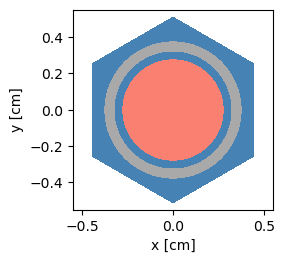

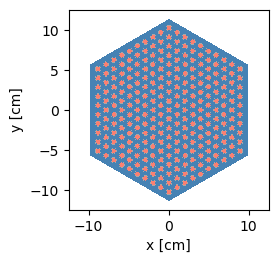

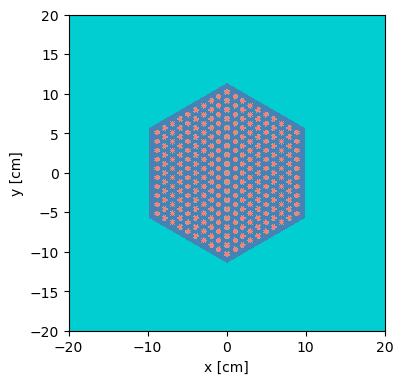

In [4]:
# geometry
## fuel assembly
### parameters
pellet_diameter = 5.5685 / 10

clad_inner_diameter = 6.4300 / 10
clad_outer_diameter = 7.5500 / 10

pin_cell_f2f = 8.9074 / 10
pin_pitch = 1.180 * pellet_diameter
duct_f2f = 15.710

### making cells
metal_or = openmc.ZCylinder(r = pellet_diameter / 2)
clad_ir = openmc.ZCylinder(r = clad_inner_diameter / 2)
clad_or = openmc.ZCylinder(r = clad_outer_diameter / 2)
outer_surface = openmc.model.HexagonalPrism(
    edge_length = pin_cell_f2f / 3**(.5)
)

metal_cell = openmc.Cell(fill = core, region = -metal_or)
fill_cell = openmc.Cell(fill = na, region = +metal_or & -clad_ir)
clad_cell = openmc.Cell(fill = ht9, region = +clad_ir & -clad_or)
outer_cell = openmc.Cell(fill = na, region = -outer_surface)
outer_fill = openmc.Cell(fill = na, region = +clad_or)

fuel_pin = openmc.Universe(cells = [metal_cell, fill_cell, clad_cell, outer_fill])
fuel_cell = openmc.Cell(fill = fuel_pin)
fuel_pin = openmc.Universe(cells = [fuel_cell])

fuel_pin_plot = openmc.Universe(cells = [metal_cell, fill_cell, clad_cell, outer_cell])

### plotting
fuel_pin_plot.plot(color_by = "material", width = [1.1, 1.1], colors = colors)
#fuel_pin.plot(color_by = "material", width = [1.1, 1.1], colors = colors)
plt.show()

### assembly layers
fuel_assembly = openmc.HexLattice()

fuel_assembly.center = (0,0)
fuel_assembly.pitch = (pin_pitch * 3**(0.5),)
fuel_assembly.outer = openmc.Universe(cells = [openmc.Cell(fill=na)])

layers = []

for i in reversed(range(1,10)):
    layers.append([fuel_pin] * (i*6))
layers.append([fuel_pin])

fuel_assembly.universes = layers

### full assembly
polygon_radius = pin_pitch * 3**(0.5) * 10
outer_hex = openmc.model.HexagonalPrism(
    edge_length = polygon_radius,
    orientation = 'y',
)

fuel_assembly_cell = openmc.Cell(fill = fuel_assembly, region = -outer_hex)

### plotting
plot_univ = openmc.Universe(cells=[fuel_assembly_cell])
plot_univ.plot(color_by = "material", width = [25 , 25], colors = colors)
plt.show()

## block of TRU
rect_prism = openmc.model.RectangularPrism(
    width = polygon_radius * 0.5,
    height = polygon_radius * 1.5,
    axis = 'z',
    origin = [1.25 * polygon_radius, 0.5 * polygon_radius]
)

tru_block = openmc.Cell(fill = tru_wg, region = -rect_prism)

"""
### plotting
tru_univ = openmc.Universe(cells=[fuel_assembly_cell, tru_block])
tru_univ.plot(color_by = 'material', width = [50, 50], colors=colors)
plt.show()
"""

## boron cylinders
zclin1 = openmc.ZCylinder(-10, -10, 5 * pin_pitch)
zclin2 = openmc.ZCylinder(-6, 13, 5 * pin_pitch)

boron_cell1 = openmc.Cell(fill = boron, region = -zclin1)
boron_cell2 = openmc.Cell(fill = boron, region = -zclin2)

## TRU cylinders
zclin3 = openmc.ZCylinder(-14, -3, 5 * pin_pitch)
zclin4 = openmc.ZCylinder(-4, -14, 5 * pin_pitch)

tru_cell1 = openmc.Cell(fill = tru_wg, region = -zclin3)
tru_cell2 = openmc.Cell(fill = tru_wg, region = -zclin4)

## bounding box
left = openmc.YPlane(y0 = -20, boundary_type = "vacuum")
right = openmc.YPlane(y0 = 20, boundary_type = "vacuum")
front = openmc.XPlane(x0 = 20, boundary_type = "vacuum")
back = openmc.XPlane(x0 = -20, boundary_type = "vacuum")

bounding_box = +left & -right & -front & +back & +outer_hex# & +zclin1 & +zclin2 & +zclin3 & +zclin4 & +rect_prism
bounding_cell = openmc.Cell(fill=water, region=bounding_box)

## entire assembly
#test_cylin = openmc.ZCylinder(0,0,polygon_radius)
#test_cell = openmc.Cell(fill = tru_wg, region = +test_cylin)

#univ = openmc.Universe(cells = [fuel_assembly_cell, tru_block, boron_cell1, boron_cell2, tru_cell1, tru_cell2, bounding_cell])
univ = openmc.Universe(cells = [bounding_cell, fuel_assembly_cell])
univ.plot(color_by = 'material', width = [40, 40], colors=colors, pixels=100000)
plt.savefig("geometry.png", dpi=600)
plt.show()

## xml
main_cell = openmc.Cell(fill = univ)
geometry = openmc.Geometry([main_cell])
geometry.export_to_xml()

## settings

In [5]:
# settings
#point1 = openmc.stats.Point((0,0,0))
point1 = openmc.stats.Box((-19,-19,-1),(19,19,1))
src1 = openmc.IndependentSource(space=point1)

settings = openmc.Settings()
settings.source = [src1]
settings.particles = 100
settings.batches = 100
settings.inactive = 50
settings.export_to_xml()

## tallies

In [13]:
# tallies
## RegularMesh
mesh_len = 250
mesh_dimensions = (mesh_len,mesh_len)
mesh = openmc.RegularMesh()

size = 20
mesh.lower_left = (-size, -size)
mesh.upper_right = (size, size)
mesh.dimension = mesh_dimensions
mesh_filter = openmc.MeshFilter(mesh, filter_id=1)

### mesh tallies
mesh_heat = openmc.Tally()
mesh_heat.scores = ['flux']
mesh_heat.filters = [mesh_filter]

#mesh_flux = openmc.Tally()
#mesh_flux.scores = ['flux']
#mesh_flux.filters = [mesh_filter]

## tallies
tallies = openmc.Tallies([mesh_heat])
tallies.export_to_xml()

## raw tallies

### RegularMesh

### DistribcellFilter

### ZernikeFilter

## running

In [14]:
!rm *.h5 *.out
openmc.run(output=False,geometry_debug=True)
#openmc.run(output=False)

In [15]:
# post-processing
## getting scores
sp = openmc.StatePoint('statepoint.100.h5')

for tally_key in sp.tallies:
    tally = sp.tallies[tally_key]

    print(tally)
#    if tally.id == mesh_heat.id: mesh_heat_scores = tally
#    if tally.id == mesh_flux.id: mesh_flux_scores = tally
    mesh_heat_scores = tally

#    if tally.id == distrib_heat.id: distrib_heat_scores = tally
#    if tally.id == distrib_flux.id: distrib_flux_scores = tally

#    if tally.id == zernike_heat.id: zernike_heat_scores = tally
#    if tally.id == zernike_flux.id: zernike_flux_scores = tally

Tally
	ID             =	3
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength
	Multiply dens. =	True


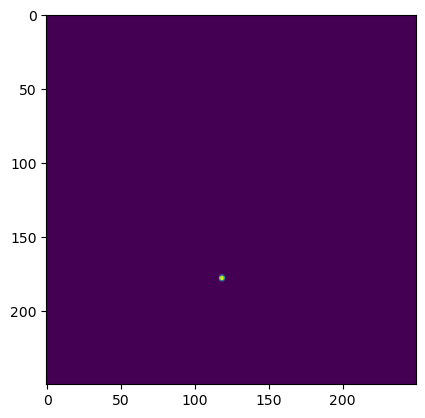

In [18]:
## mesh
mesh_heat_scores.std_dev.shape = mesh_dimensions
mesh_heat_scores.mean.shape = mesh_dimensions

#mesh_flux_scores.std_dev.shape = mesh_dimensions
#mesh_flux_scores.mean.shape = mesh_dimensions

mesh_heat_plot = plt.subplot()
mesh_heat_plot.imshow(mesh_heat_scores.mean)

#plt.savefig("post/mesh_heat.png", dpi=600)
#plt.show()

#mesh_flux_plot = plt.subplot()
#mesh_flux_plot.imshow(mesh_flux_scores.mean)
#plt.savefig("post/mesh_flux.png", dpi=600)
#plt.show()

In [ ]:
## circular zernike
zernike_heat_df = zernike_heat_scores.get_pandas_dataframe()
zernike_flux_df = zernike_flux_scores.get_pandas_dataframe()

zernike_heat_n = zernike_flux_df['mean']
zernike_flux_n = zernike_flux_df['mean']

zernike_heat_zernikes = openmc.Zernike(zernike_heat_n, radius = polygon_radius)
zernike_flux_zernikes = openmc.Zernike(zernike_flux_n, radius = polygon_radius)

### coordinates
azimuths = np.radians(np.linspace(0,360,100))
zeniths = np.linspace(0,polygon_radius,100)
r,theta = np.meshgrid(zeniths, azimuths)

z_heat_values = zernike_heat_zernikes(zeniths, azimuths)
z_flux_values = zernike_flux_zernikes(zeniths, azimuths)

### plotting
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
plot = ax.contourf(theta,r,z_heat_values,cmap="jet")
cbar = fig.colorbar(plot)
plt.savefig("post/z_heat.png", dpi=600)
plt.show()

fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
plot = ax.contourf(theta,r,z_flux_values,cmap="jet")
cbar = fig.colorbar(plot)
plt.savefig("post/z_flux.png", dpi=600)
plt.show()

In [ ]:
## polygon zernike
### put the circular filters here, but using circular data for now
"""
polygon_heat_df = polygon_heat_scores.get_pandas_dataframe()
polygon_flux_df = polygon_flux_scores.get_pandas_dataframe()

polygon_heat_n = polygon_flux_df['mean']
polygon_flux_n = polygon_flux_df['mean']

polygon_heat_zernikes = openmc.Zernike(polygon_heat_n, radius = polygon_radius)
polygon_flux_zernikes = openmc.Zernike(polygon_flux_n, radius = polygon_radius)
"""
### transforming
num_sides = 6
alpha = np.pi / num_sides

def r_alpha(theta):
    drop = (theta + alpha) / (2 * alpha)
    u_alpha = theta - drop.astype(int) * (2 * alpha) 

    return polygon_radius * np.cos(alpha) / np.cos(u_alpha)

var_radius = r_alpha(theta)
rp = r * var_radius / polygon_radius

### values
"""
k_heat_values = polygon_heat_zernikes(zeniths, azimuths)
k_flux_values = polygon_flux_zernikes(zeniths, azimuths)
"""

k_heat_values = zernike_heat_zernikes(zeniths, azimuths)
k_flux_values = zernike_flux_zernikes(zeniths, azimuths)

### plotting
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
plot = ax.contourf(theta,rp,k_heat_values,cmap="jet")
cbar = fig.colorbar(plot)
plt.savefig("post/k_heat.png")
plt.show()

fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
plot = ax.contourf(theta,rp,k_flux_values,cmap="jet")
cbar = fig.colorbar(plot)
plt.savefig("post/k_flux.png")
plt.show()

## raw post processing

### SimpleMesh post-processing

### DistribcellFilter post-processing

### Zernike Post Processing